In [1]:
import numpy as np
import pandas as pd
import sklearn
import cv2
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import dlib

In [2]:
import efficientnet.tfkeras as efn

In [3]:
tf.__version__

'2.2.0'

In [ ]:
def plotImage(img, box, fiducial=None):
    if type(img) == str:
        print("Filename: ", img)
        img = cv2.imread(img)
        img = cv2.cvtColor(cv2.COLOR_BGR2RGB)

# Datasets -->

## Load Premade TFDS datasets -->

In [4]:
# Construct a tf.data.Dataset
lfw = tfds.load('lfw', shuffle_files=True)['train']

In [5]:
vgg = tfds.image_classification.VggFace2()
config = tfds.download.DownloadConfig(manual_dir='/ntfs/Datasets/vgg/')
vgg.download_and_prepare(download_config=config, download_dir='/ntfs/TensorflowDatasets/')
train = vgg.as_dataset(split='train')
test = vgg.as_dataset(split='test')

In [96]:
a = test.batch(1).as_numpy_iterator()

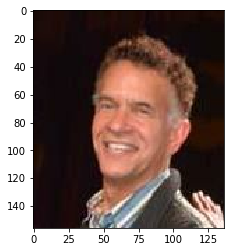

In [100]:
plt.imshow(a.next()['image'][0])

In [28]:
[i for i in a]

['file_name', 'image', 'label']

## Construct Custom Datasets -->

### VGG ==>

In [8]:
def loadVGG(base='Datasets/vgg/', type='train'):
#     f = open(base + type + '_list.txt', 'r').read().split('\n')[:-1]
#     for i in f:
#         idd, 
    landmarks = pd.read_csv(base + 'bb_landmark/loose_landmark_' + type + '.csv')
    bbs = pd.read_csv(base + 'bb_landmark/loose_bb_' + type + '.csv')
    merged = pd.merge(landmarks, bbs)
    data = []
    for iterr, sample in merged.iterrows():
        nameid = sample['NAME_ID']
        fname = base + 'vggface2_' + type + '/' + type + '/' + nameid + '.jpg'
        box = [sample['X'], sample['Y'], sample['X'] + sample['W'], sample['Y'] + sample['H']]
        fiducial = [
            sample['P1X'], sample['P1Y'],
            sample['P2X'], sample['P2Y'],
            sample['P3X'], sample['P3Y'],
            sample['P4X'], sample['P4Y'],
            sample['P5X'], sample['P5Y']
        ]
        data.append({
            'fname' : fname,
            'box' : box,
            'fiducial' : fiducial
        })

    return pd.DataFrame(data)

In [9]:
trainVGG = loadVGG(type='train')
# testVGG = loadVGG(type='test')

### - Processing

# Dataset Loading -->

# Model Preparation -->

In [17]:
CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

def getModel(inputShape=(256, 256, 3), backbone='resnet', embed_shape=512, activation=tfa.activations.mish, kernel_initializer=CONV_KERNEL_INITIALIZER):
    x = inputs = tf.keras.layers.Input(shape=inputShape, name='image')
    if backbone == 'resnet50':
        backboneArch = tf.keras.applications.ResNet50(
            include_top=False, weights='imagenet', input_tensor=None,
            pooling=None
        )(x)
    elif backbone == 'densenet169':
        backboneArch = tf.keras.applications.DenseNet169(
            include_top=False, weights='imagenet', input_tensor=None,
            pooling=None
        )(x)
    elif backbone == 'resnet':
        backboneArch = tf.keras.applications.ResNet50(
            include_top=False, weights='imagenet', input_tensor=None,
            pooling=None
        )(x)
    elif backbone == 'efficientnet':
        backboneArch = efn.EfficientNetB0(
            include_top=False, weights='imagenet', input_tensor=None,
            pooling=None
        )(x)
        
    def OutputLayer(w_decay=5e-4, name='OutputLayer'):
        """Output Later"""
        def output_layer(x_in):
            x = inputs = x_in
            x = tf.keras.layers.BatchNormalization()(x)
#             print(x.shape)
#             x = tf.keras.layers.Flatten()(x)
#             print(x.shape)
#             x = tf.keras.layers.Dense(embed_shape, kernel_regularizer=tf.keras.regularizers.l2(w_decay))(x)
#             x = tf.keras.layers.Conv2D(512, kernel_size=(1, 1), activation=activation, kernel_initializer=kernel_initializer)(x)
            x = tf.keras.layers.GlobalAvgPool2D()(x)
#             x = tf.keras.layers.Flatten()(x)
            x = tf.keras.layers.Dense(embed_shape, kernel_regularizer=tf.keras.regularizers.l2(w_decay))(x)
            x = tf.keras.layers.BatchNormalization(name=name)(x)
            print(x.shape)
            return x
        return output_layer
    
    output = OutputLayer()(backboneArch)
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    def autoEnc():
        def auto_enc(x_in, prev):
#             x = inputs = x_in
#             x = tf.keras.layers.Reshape(target_shape=(16, 16, embed_shape // (256)))(x)
#             print(x.shape)
            prev = tf.keras.layers.UpSampling2D((2, 2))(prev)
            print(prev.shape)
            x = prev
#             x = tf.keras.layers.Concatenate(axis=-1)([prev, x])
            
            x = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=2, padding='same', activation=activation, kernel_initializer=kernel_initializer)(x)
            x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation=activation, kernel_initializer=kernel_initializer)(x)
            x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation=activation, kernel_initializer=kernel_initializer)(x)
            x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, padding='same', activation=activation, kernel_initializer=kernel_initializer)(x)
            print(x.shape)
            return x
        return auto_enc
    
#     dec_in = tf.keras.layers.Input(shape=output.shape)
    decoder = autoEnc()(output, backboneArch)
#     decoder = tf.keras.models.Model()
    autoenc = tf.keras.models.Model(inputs = inputs, outputs = decoder)
    
    return model, autoenc

In [10]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='image')
backboneArch = tf.keras.applications.ResNet50(
            include_top=False, weights='imagenet', input_tensor=None,
            pooling=None
        )(inputs)

In [11]:
backboneArch.shape

TensorShape([None, 7, 7, 2048])

In [18]:
model, autoenc = getModel((224, 224, 3), 'resnet', embed_shape=512, activation=tfa.activations.mish,  kernel_initializer=tf.keras.initializers.lecun_normal())

(None, 512)
(None, 14, 14, 2048)
(None, 224, 224, 3)


In [19]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 2048)        8192      
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
OutputLayer (BatchNormalizat (None, 512)               2048      
Total params: 24,647,040
Trainable params: 24,588,800
Non-trainable params: 58,240
__________________________________________

In [61]:
model.output_shape

(None, 512)

In [66]:
schedule = tf.keras.optimizers.schedules.InverseTimeDecay(1.,decay_steps=1*5,decay_rate=1,staircase=False)
step = tf.Variable(0, trainable=False)
lr = 0.001*schedule(step) 
wd = 0.0001#*schedule(step)
optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
loss = tf.keras.losses.MeanAbsoluteError()
autoenc.compile(optimizer = tfa.optimizers.Lookahead(optimizer), loss=loss, metrics=['accuracy', 'mae'])
# model.compile(optimizer = tfa.optimizers.Lookahead(optimizer), loss=regressionLoss, metrics=['accuracy', 'mae'])
autoenc.summary()
# tf.keras.utils.plot_model(model)

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Model)      multiple                  4049564   
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 16, 16, 1280)      0         
_________________________________________________________________
conv2d_transpose_38 (Conv2DT (None, 32, 32, 512)       5898752   
_________________________________________________________________
conv2d_transpose_39 (Conv2DT (None, 64, 64, 128)       589952    
_________________________________________________________________
conv2d_transpose_40 (Conv2DT (None, 128, 128, 64)      73792     
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 256, 256, 3)       173

# Pretraining -->

In [79]:
trainSet = train.batch(40)
testSet = test.batch(40)

In [84]:
@tf.function
def trainer(model, trainSet, testSet, epochs=10):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    for i in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        for data in trainSet:
            
#             with tf.GradientTape() as tape:
#                 loss = compute_loss(model, x)
#             gradients = tape.gradient(loss, model.trainable_variables)
#             optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [85]:
trainer(autoenc, testSet, testSet)

file_name
file_name
file_name
file_name
file_name
file_name
file_name
file_name
file_name
file_name


InvalidArgumentError:  Cannot batch tensors with different shapes in component 1. First element had shape [130,113,3] and element 1 had shape [563,532,3].
	 [[node ReduceDataset (defined at <ipython-input-84-f81403263afd>:11) ]] [Op:__inference_trainer_231233]

Function call stack:
trainer


# Training Loop -->

In [ ]:
schedule = tf.keras.optimizers.schedules.InverseTimeDecay(1.,decay_steps=1*5,decay_rate=1,staircase=False)
step = tf.Variable(0, trainable=False)
lr = 0.001*schedule(step) 
wd = 0.0001#*schedule(step)
optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
model.compile(optimizer = tfa.optimizers.Lookahead(optimizer), loss=, metrics=['accuracy', 'mae'])
# model.compile(optimizer = tfa.optimizers.Lookahead(optimizer), loss=regressionLoss, metrics=['accuracy', 'mae'])
model.summary()
# tf.keras.utils.plot_model(model)